# <center>Udacity Machine Learning Nanodegree Capstone Project</center>
## <center>David S. Price - May 2019</center>

This project proposal was inspired by a Kaggle competition project called <a href="https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria">“Malaria Cell Images Dataset - Cell Images for Detecting Malaria”</a>.  The intent is to save humans by developing an algorithm to determine whether image cells show infestation by malaria. The dataset of images (which actually comes from the NIH) contains cell images in two categories – those parasitized by malaria and those uninfected.

In this notebook, a convolutional neural network (CNN) is developed, benchmarked, and trained to detect the differences.  The full database is fairly large, containing 27,558 images evenly divided between parasitized and uninfected cells.  This database is allocated as follows:
* Train Images - 70% - 19,290 total images (9645 each for parasitized and uninfected)
* Validation Images - 10% - 2,756 total images (1378 each for parasitized and uninfected)
* Test Images - 20% - 5,512 total images (2756 each for parasitized and uninfected)

The code allows for the option to run just a subset of the images, which can be quite useful when further developing the code structure and quick feedback is valuable.  The subset database is fairly small, containing only 200 images evenly divided between parasitized and uninfected cells.  This database is allocated as follows:
* Train Images - 70% - 140 total images (70 each for parasitized and uninfected)
* Validation Images - 10% - 20 total images (10 each for parasitized and uninfected)
* Test Images - 20% - 40 total images (20 each for parasitized and uninfected)

The code is structured for multiple uses, including users using a GPU environment and those using just a CPU environment, and a one-layer CNN for benchmarking.  These are all control parameters the user can set in one of the early code cells.


In [74]:
#Import the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint 

#import others
import pandas as pd
import itertools
import keras
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_curve, auc, confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [75]:
#Establish Control Parameters for the various output options available

#Given the enormous size of the image database, it's important to know in advance what
#the user intends to accomplish with running the code in this notebook as forgetting a
#parameter can lead to hours of processing which may not be desired at that time.

#Set parameter to either evaluate full image set (>27k files) or just a subset (200 files) 
#for algorithm development
USE_FULL_IMAGE_SET = True

#Set parameter to run benchmark code
RUN_BENCHMARK_CODE = True

#Set training parameters based on whether running on GPU
USING_GPU = False

#Echo settings to user
print("USE_FULL_IMAGE_SET : ",USE_FULL_IMAGE_SET)
print("RUN_BENCHMARK_CODE : ",RUN_BENCHMARK_CODE)
print("USING_GPU : ",USING_GPU)

USE_FULL_IMAGE_SET :  True
RUN_BENCHMARK_CODE :  True
USING_GPU :  False


In [76]:
#Pre-process cell images

#Call ImageDataGenerator to generate batches of tensor image data with real-time 
#data augmentation. The data will be looped over (in batches).

train_datagen = ImageDataGenerator(rescale = 1./255, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

validation_datagen = ImageDataGenerator(rescale = 1./255)

#Set image file path accordingly
if USE_FULL_IMAGE_SET == True:
    print("Using FULL image set\n")
    training_set_image_path = 'cell_images_full/train'
    test_set_image_path = 'cell_images_full/test'
    validation_set_image_path = 'cell_images_full/valid'
    
else:
    print("Using small SUBSET image set\n")
    training_set_image_path = 'cell_images_subset/train'
    test_set_image_path = 'cell_images_subset/test'
    validation_set_image_path = 'cell_images_subset/valid'
    
#Apply method "flow_from_directory" which takes the path to a directory & generates batches
#of augmented data, returning a "DirectoryIterator" yielding tuples of (x, y) where x is 
#a numpy array containing a batch of images with shape (batch_size, *target_size, channels) 
#and y is a numpy array of corresponding labels.

BATCH_SIZE = 32

training_set = train_datagen.flow_from_directory(training_set_image_path, 
                                                 target_size = (64, 64), 
                                                 batch_size = BATCH_SIZE, 
                                                 class_mode = 'categorical')

#Set batch_size to 1 to force 1 entry per image - critical for the prediction step later on
test_set = test_datagen.flow_from_directory(test_set_image_path, 
                                            target_size = (64, 64), 
                                            batch_size = 1, 
                                            class_mode = 'categorical')
 
validation_set = validation_datagen.flow_from_directory(validation_set_image_path, 
                                                        target_size = (64, 64), 
                                                        batch_size = BATCH_SIZE, 
                                                        class_mode = 'categorical')

print("\nFinished pre-processing cell images")

Using FULL image set

Found 19290 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.

Finished pre-processing cell images


In [77]:
#Set training parameters based on whether running on GPU

if USING_GPU == True:
    print("Running in GPU mode")
    NUMBER_STEPS_PER_EPOCH = 5000
    NUMBER_OF_EPOCHS = 10
    BATCH_SIZE = 32
    NUMBER_VALIDATION_STEPS = 2000
else:
    print("Running in CPU (not GPU) mode")
    NUMBER_STEPS_PER_EPOCH = 1000
    NUMBER_OF_EPOCHS = 10
    BATCH_SIZE = 5
    NUMBER_VALIDATION_STEPS = 100
    
print("     # of steps per epoch  : ", NUMBER_STEPS_PER_EPOCH)
print("     # of epochs           : ", NUMBER_OF_EPOCHS)
print("     # of validation steps : ", NUMBER_VALIDATION_STEPS)

Running in CPU (not GPU) mode
     # of steps per epoch  :  1000
     # of epochs           :  10
     # of validation steps :  100




In [78]:
#Create benchmark model if mode activated

if RUN_BENCHMARK_CODE == True:
    #Initializing the CNN
    benchmark_model = Sequential()

    #Step 1 - Convolution
    benchmark_model.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))

    #Step 2 - Pooling
    benchmark_model.add(MaxPooling2D(pool_size = (2, 2)))
    #TODO - Determine if dropout is needed.  If so, add it to full model
    benchmark_model.add(Dropout(0.2))

    #Step 3 - Flattening
    benchmark_model.add(Flatten())

    #Step 4 - Full connection
    benchmark_model.add(Dense(units = 128, activation = 'relu'))
    benchmark_model.add(Dense(units = 2, activation = 'softmax'))

    #Compiling the CNN
    benchmark_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

    print("finished compiling benchmark model")

finished compiling benchmark model


In [79]:
# train the benchmark model if mode activated
if RUN_BENCHMARK_CODE == True:
    benchmark_checkpointer = ModelCheckpoint(filepath='saved_models/benchmark_model.weights.best.hdf5', 
                                             verbose=1, 
                                             save_best_only=True)

    #Fit the benchmark model
    benchmark_model.fit_generator(training_set, 
                                  steps_per_epoch = NUMBER_STEPS_PER_EPOCH, 
                                  epochs = NUMBER_OF_EPOCHS, 
                                  callbacks=[benchmark_checkpointer], 
                                  validation_data = validation_set, 
                                  validation_steps = NUMBER_VALIDATION_STEPS)

    print("\nFinished benchmark model fitting of malaria-infected cell images to one-layer CNN")

Epoch 1/10
1000/1000 [==============================] - 354s - loss: 0.5851 - acc: 0.7095 - val_loss: 0.9364 - val_acc: 0.6283
Epoch 2/10
1000/1000 [==============================] - 389s - loss: 0.3906 - acc: 0.8372 - val_loss: 0.5948 - val_acc: 0.7371
Epoch 3/10
1000/1000 [==============================] - 5903s - loss: 0.2529 - acc: 0.9065 - val_loss: 0.4521 - val_acc: 0.8077
Epoch 4/10
1000/1000 [==============================] - 297s - loss: 0.2007 - acc: 0.9305 - val_loss: 0.3328 - val_acc: 0.8376
Epoch 5/10
1000/1000 [==============================] - 296s - loss: 0.1914 - acc: 0.9347 - val_loss: 0.3827 - val_acc: 0.8373
Epoch 6/10
1000/1000 [==============================] - 298s - loss: 0.1710 - acc: 0.9433 - val_loss: 0.2767 - val_acc: 0.8623
Epoch 7/10
1000/1000 [==============================] - 294s - loss: 0.1701 - acc: 0.9434 - val_loss: 0.3123 - val_acc: 0.8903
Epoch 8/10
1000/1000 [==============================] - 293s - loss: 0.1674 - acc: 0.9457 - val_loss: 0.2672 -

In [80]:
# Load the benchmark model weights with the best validation loss if mode activated
if RUN_BENCHMARK_CODE == True:
    benchmark_model.load_weights('saved_models/benchmark_model.weights.best.hdf5')


In [81]:
#Determine # of image files in the test set if mode activated
if RUN_BENCHMARK_CODE == True:
    filenames = test_set.filenames
    number_test_set_samples = len(filenames)
    print("number of test set samples = ",number_test_set_samples)

    benchmark_predict = benchmark_model.predict_generator(test_set,steps = number_test_set_samples)

    print("finished with benchmark predict generator")
    print("benchmark.predict.shape is: ")
    print(benchmark_predict.shape)

number of test set samples =  5512
finished with benchmark predict generator
benchmark.predict.shape is: 
(5512, 2)


In [82]:
#Step 8 - Calculate the Classification Accuracy on the Test Set if mode activated

if RUN_BENCHMARK_CODE == True:
    benchmark_score = benchmark_model.evaluate_generator(test_set, steps = number_test_set_samples)

    benchmark_accuracy = 100*benchmark_score[1]

    print('Benchmark Test accuracy: %.4f%%' % benchmark_accuracy)

Benchmark Test accuracy: 94.1763%


In [83]:
#Create full model

#Initializing the CNN
model = Sequential()

#Step 1 - Convolution
model.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))

#Step 2 - Pooling
model.add(MaxPooling2D(pool_size = (2, 2)))

#Adding a second convolutional layer
model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

#adding 3rd layer
model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

#Step 3 - Flattening
model.add(Flatten())

#Step 4 - Full connection
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dense(units = 2, activation = 'softmax'))

#Compiling the CNN
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

print("finished compiling")

model.summary()

print("finished summary")

finished compiling
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 1152)              0 

In [84]:
# train the model
checkpointer = ModelCheckpoint(filepath='saved_models/model.weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)
    
#Fit the model
model.fit_generator(training_set, 
                    steps_per_epoch = NUMBER_STEPS_PER_EPOCH, 
                    epochs = NUMBER_OF_EPOCHS, 
                    callbacks=[checkpointer], 
                    validation_data = validation_set, 
                    validation_steps = NUMBER_VALIDATION_STEPS)

print("\nFinished model fitting of malaria-infected cell images to 3 layer CNN")

Epoch 1/10
1000/1000 [==============================] - 229s - loss: 0.3287 - acc: 0.8489 - val_loss: 0.2706 - val_acc: 0.9029
Epoch 2/10
1000/1000 [==============================] - 242s - loss: 0.1527 - acc: 0.9502 - val_loss: 0.2144 - val_acc: 0.9307
Epoch 3/10
1000/1000 [==============================] - 256s - loss: 0.1349 - acc: 0.9553 - val_loss: 0.2057 - val_acc: 0.9310
Epoch 4/10
1000/1000 [==============================] - 262s - loss: 0.1291 - acc: 0.9561 - val_loss: 0.2732 - val_acc: 0.8859
Epoch 5/10
1000/1000 [==============================] - 257s - loss: 0.1217 - acc: 0.9600 - val_loss: 0.2206 - val_acc: 0.9288
Epoch 6/10
1000/1000 [==============================] - 258s - loss: 0.1147 - acc: 0.9616 - val_loss: 0.2459 - val_acc: 0.9098
Epoch 7/10
1000/1000 [==============================] - 257s - loss: 0.1140 - acc: 0.9606 - val_loss: 0.2080 - val_acc: 0.9310
Epoch 8/10
1000/1000 [==============================] - 256s - loss: 0.1129 - acc: 0.9611 - val_loss: 0.2179 - 

In [85]:
# Load the model weights with the best validation loss.

model.load_weights('saved_models/model.weights.best.hdf5')


In [86]:
#Determine # of image files in the test set
filenames = test_set.filenames
number_test_set_samples = len(filenames)
print("number of test set samples = ",number_test_set_samples)

#print(filenames)

predict = model.predict_generator(test_set,steps = number_test_set_samples)

print("finished with predict generator")
print("predict.shape is: ")
print(predict.shape)

number of test set samples =  5512
finished with predict generator
predict.shape is: 
(5512, 2)


In [87]:
#Step 8 - Calculate the Classification Accuracy on the Test Set

score = model.evaluate_generator(test_set, steps = number_test_set_samples)

accuracy = 100*score[1]

print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 92.0900%


In [88]:
#create output .csv file for testing

In [130]:
#function to produce a predictions file for use with ROC and CM
def produce_predictions_file(benchmark = False):
        
    #Create dataframes to hold predictions
    y_pred = pd.DataFrame(columns=["id","task_1", "task_2"])
    y_pred_sorted = pd.DataFrame(columns=["id","task_1", "task_2"])
    ground_truth = pd.DataFrame(columns=["id","task_1", "task_2"])

    #The order of images in the test_set is not likely to be the same as the ground_truth file,
    #therefore, the predictions file must be sorted to be in the same order as the ground_truth file.
    #Design note: Sort the predictions file instead of ground_truth so as to not potentially 
    #corrupt the ground_truth file.
    
    #set predict_file to either the benchmark or model predictions
    if benchmark == True:
        predict_file = benchmark_predict
    else:
        predict_file = predict

    if USE_FULL_IMAGE_SET == True:
        ground_truth = pd.read_csv('ground_truth_files/ground_truth_full.csv')    
    else:
        ground_truth = pd.read_csv('ground_truth_files/ground_truth_subset.csv')

    #Prepare y_pred file to contain:
    #     id - image filaname
    #     task_1 : 1 if probability of being parasitized is >= 50%; else 0
    #     task_2 : 0 if probability of being parasitized is >= 50%; else 1
    #So, [1 0] means cell is parasitized and [0 1] means uninfected

    for ii in range(len(predict_file)):
        y_pred.loc[ii, "id"] = filenames[ii]
        if predict_file[ii][0] >= 0.5:
            y_pred.loc[ii, "task_1"] = 1
            y_pred.loc[ii, "task_2"] = 0
        else:
            y_pred.loc[ii, "task_1"] = 0
            y_pred.loc[ii, "task_2"] = 1

    #Export data into a .csv file
    if benchmark == True:
        y_pred.to_csv("prediction_files/benchmark_predictions.csv")
    else:
        y_pred.to_csv("prediction_files/predictions.csv")

In [131]:
#Product sorted predictions file

#Produce a sorted predictions file for the benchmark code (if needed) for use in ROC and CM
if RUN_BENCHMARK_CODE == True:
    produce_predictions_file(True)
    print("Produced benchmark_predictions .csv file\n")

produce_predictions_file(False)
print("Produced predictions .csv file")


Produced benchmark_predictions .csv file

Produced predictions .csv file


In [132]:
#Internal Testing vs. Ground Truths

In [133]:
def plot_roc_auc(y_true, y_pred):
    """
    This function plots the ROC curves and provides the scores.
    """

    # initialize dictionaries and array
    fpr = dict()
    tpr = dict()
    roc_auc = np.zeros(3)
    
    # prepare for figure
    plt.figure()
    colors = ['aqua', 'cornflowerblue']

    # for both classification tasks (categories 1 and 2)
    for i in range(2):
        # obtain ROC curve
        fpr[i], tpr[i], _ = roc_curve(y_true[:,i], y_pred[:,i])
        # obtain ROC AUC
        roc_auc[i] = auc(fpr[i], tpr[i])
        # plot ROC curve
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
                 label='ROC curve for task {d} (area = {f:.2f})'.format(d=i+1, f=roc_auc[i]))
    # get score for category 3
    roc_auc[2] = np.average(roc_auc[:2])
    
    # format figure
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves')
    plt.legend(loc="lower right")
    plt.show()
    
    # print scores
    for i in range(3):
        print('Category {d} Score: {f:.3f}'. format(d=i+1, f=roc_auc[i]))

def plot_confusion_matrix(y_true, y_pred, thresh, classes):
    """
    This function plots the (normalized) confusion matrix.
    """

    # obtain class predictions from probabilities
    # obtain (unnormalized) confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # normalize confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

ROC and confusion matrix for Benchmark


C:\Users\david\Anaconda3\envs\dog-project\lib\site-packages\ipykernel\__main__.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\david\Anaconda3\envs\dog-project\lib\site-packages\ipykernel\__main__.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


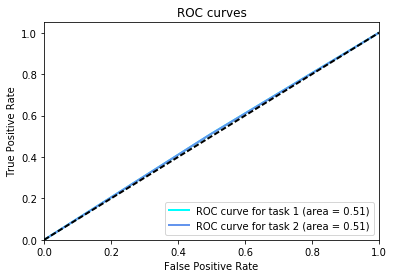

Category 1 Score: 0.507
Category 2 Score: 0.507
Category 3 Score: 0.507


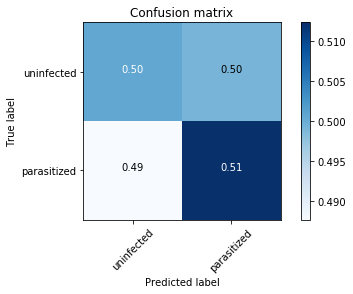

finished producing benchmark ROC and CM

ROC and confusion matrix for model


C:\Users\david\Anaconda3\envs\dog-project\lib\site-packages\ipykernel\__main__.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


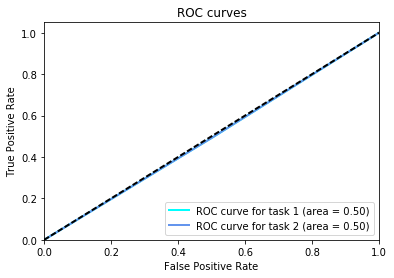

Category 1 Score: 0.496
Category 2 Score: 0.496
Category 3 Score: 0.496


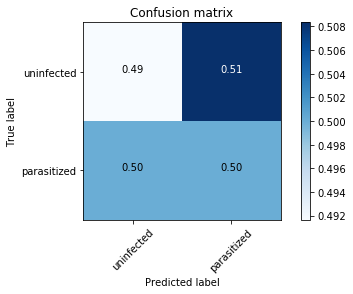

In [134]:
#Produce ROC and CM

#Set threshold
thresh = 0.5

# get ground truth labels for test dataset
if USE_FULL_IMAGE_SET == True:
    truth = pd.read_csv('ground_truth_files/ground_truth_full.csv')    
else:
    truth = pd.read_csv('ground_truth_files/ground_truth_subset.csv')

y_true = truth.as_matrix(columns=["task_1", "task_2"])

#If running benchmark code, then create ROC and confusion matrix for Benchmark code
if RUN_BENCHMARK_CODE == True:
    print("ROC and confusion matrix for Benchmark")
    # get model predictions for test dataset
    y_pred = pd.read_csv("prediction_files/benchmark_predictions.csv")
    y_pred = y_pred.as_matrix(columns=["task_1", "task_2"])
    
    # plot ROC curves and print scores
    plot_roc_auc(y_true, y_pred)
    # plot confusion matrix
    classes = ['uninfected', 'parasitized']
    plot_confusion_matrix(y_true[:,0], y_pred[:,0], thresh, classes)
    print("finished producing benchmark ROC and CM\n")

print("ROC and confusion matrix for model")
# get model predictions for test dataset and display ROC and confusion matrix for model
y_pred = pd.read_csv("prediction_files/predictions.csv")
y_pred = y_pred.as_matrix(columns=["task_1", "task_2"])
    
# plot ROC curves and print scores
plot_roc_auc(y_true, y_pred)
# plot confusion matrix
classes = ['uninfected', 'parasitized']
plot_confusion_matrix(y_true[:,0], y_pred[:,0], thresh, classes)

In [ ]:
#new


In [69]:
#TODO - copy to benchmark section once working

import pandas as pd
        
#Create dataframes to hold predictions
y_pred = pd.DataFrame(columns=["id","task_1", "task_2"])
y_pred_sorted = pd.DataFrame(columns=["id","task_1", "task_2"])
ground_truth = pd.DataFrame(columns=["id","task_1", "task_2"])

#The order of images in the test_set is not likely to be the same as the ground_truth file,
#therefore, the predictions file must be sorted to be in the same order as the ground_truth file.
#Design note: Sort the predictions file instead of ground_truth so as to not potentially 
#corrupt the ground_truth file.

len_predict = len(predict)

if USE_FULL_IMAGE_SET == True:
    ground_truth = pd.read_csv('ground_truth_full.csv')    
else:
    ground_truth = pd.read_csv('ground_truth_subset.csv')

len_ground_truth = len(ground_truth)
print("Length of Predict = ",len_predict)
print("Length of Ground Truth = ",len_ground_truth)

#Prepare y_pred file to contain:
#     id - image filaname
#     task_1 : 1 if probability of being parasitized is >= 50%; else 0
#     task_2 : 0 if probability of being parasitized is >= 50%; else 1
#So, [1 0] means cell is parasitized and [0 1] means uninfected

for ii in range(len(predict)):
    y_pred.loc[ii, "id"] = filenames[ii]
    if predict[ii][0] >= 0.5:
        y_pred.loc[ii, "task_1"] = 1
        y_pred.loc[ii, "task_2"] = 0
    else:
        y_pred.loc[ii, "task_1"] = 0
        y_pred.loc[ii, "task_2"] = 1

y_pred.to_csv("prediction_files/predictions_unsorted.csv")

print("produced unsorted predictions .csv file")

#The order of images in the test_set is not likely to be the same as the ground_truth file,
#therefore, the predictions file must be sorted to be in the same order as the ground_truth file
#(so as to not potentially corrupt the ground_truth file).

#Create new prediction file sorted in same order as ground_truth.  For each entry in ground_truth,
#search through prediction file for same entry.  Store in new array called y_pred_sorted.
#This will result in y_pred_sorted having files in same order as ground_truth making the ROC/CM
#computations easier.

for i in range(len(ground_truth)):
    #print("i = ", i)
    for ii in range(len(y_pred)):
        if ground_truth.loc[i, "id"] == y_pred.loc[ii, "id"]:
            #DELETE
            print("i = ", i, " ii = ", ii)
            y_pred_sorted.loc[i, "id"] = y_pred.loc[ii, "id"]
            y_pred_sorted.loc[i, "task_1"] = y_pred.loc[ii, "task_1"]
            y_pred_sorted.loc[i, "task_2"] = y_pred.loc[ii, "task_2"]
            break #once entry found, no need to keep looping
            
y_pred_sorted.to_csv("prediction_files/predictions.csv")

print("produced .csv file")

Length of Predict =  5512
Length of Ground Truth =  5512
produced unsorted predictions .csv file
i =  0
i =  1
i =  2
i =  3
i =  4
i =  5
i =  6
i =  7
i =  8
i =  9
i =  10
i =  11
i =  12
i =  13
i =  14
i =  15
i =  16
i =  17
i =  18
i =  19
i =  20
i =  21
i =  22
i =  23
i =  24
i =  25
i =  26
i =  27
i =  28
i =  29
i =  30
i =  31
i =  32
i =  33
i =  34
i =  35
i =  36
i =  37
i =  38
i =  39
i =  40
i =  41
i =  42
i =  43
i =  44
i =  45
i =  46
i =  47
i =  48
i =  49
i =  50
i =  51
i =  52
i =  53
i =  54
i =  55
i =  56
i =  57
i =  58
i =  59
i =  60
i =  61
i =  62
i =  63
i =  64
i =  65
i =  66
i =  67
i =  68
i =  69
i =  70
i =  71
i =  72
i =  73
i =  74
i =  75
i =  76
i =  77
i =  78
i =  79
i =  80
i =  81
i =  82
i =  83
i =  84
i =  85
i =  86
i =  87
i =  88
i =  89
i =  90
i =  91
i =  92
i =  93
i =  94
i =  95
i =  96
i =  97
i =  98
i =  99
i =  100
i =  101
i =  102
i =  103
i =  104
i =  105
i =  106
i =  107
i =  108
i =  109
i =  110
i =  111
i =  